# Task 1
### Below code is used for creating model that predicts number of passenger deaths using poisson distribution in two ways.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import stan_utility
import scipy.stats as stats
import arviz as az

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

df = pd.read_csv("airlines.csv") 

deaths = []
dta_cnt = []
for k in df['Passenger deaths']:  
    dta_cnt.append(-(1. + deaths.count(k)))
    deaths.append(k)
dta_cnt = np.array(dta_cnt)

df

,Year,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
0,1976,24,734,0.19,3863.0
1,1977,25,516,0.12,4300.0
2,1978,31,754,0.15,5027.0
3,1979,31,877,0.16,5481.0
4,1980,22,814,0.14,5814.0
5,1981,21,362,0.06,6033.0
6,1982,26,764,0.13,5877.0
7,1983,20,809,0.13,6223.0
8,1984,16,223,0.03,7433.0
9,1985,22,1066,0.15,7107.0


## Constant rate for all years and not depending on anything
We start our modelling by proposing very simple model, with an assumption, that Passenger deaths number $y_i$ has a Poisson distribution$$y_i\sim\mathrm{Poisson}(\lambda)$$with a rate $\lambda$ independent on year or miles flown.

Lets assume that 20 people dying every day has very low probability (20*365=7300). Following equation should be fullfilled: $$\lambda + 3\sqrt{\lambda} \approx 7300$$ which means that probability is less than 1%.

In [2]:
root_of_lam = np.polynomial.polynomial.polyroots([-7300.,3.,1.])
lam_ub = np.round(root_of_lam[root_of_lam > 0]**2)
lam_ub

array([7048.])

Below Stan code will be used to find parameter $\sigma$ of half normal distribution that will make most values to be spread between 0 and $\lambda$.

In [3]:
with open('prior_tune.stan', 'r') as file:
    print(file.read())

functions {
  vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[1] deltas;
    deltas[1] = 2 * (normal_cdf(theta[1], 0, exp(y[1])) - 0.5) - 0.99;
    return deltas;
  }
}

data {
  vector[1] y_guess;
  vector[1] theta;
}

transformed data {
  vector[1] y;
  real x_r[0];
  int x_i[0];
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i);
  print("Standard deviation = ", exp(y[1]));
}

generated quantities {
  real sigma = exp(y[1]);
}


In [4]:
model = stan_utility.compile_model('prior_tune.stan')

Using cached StanModel


In [5]:
data = dict(y_guess=np.array([np.log(10000)]), theta=np.array(lam_ub))
sim = model.sampling(data=data,
                     seed=1052020,
                     algorithm="Fixed_param",
                     iter=1, 
                     warmup=0,
                     chains=1)
sigma = np.round(sim.extract()['sigma'][0])
print(sigma)

2736.0


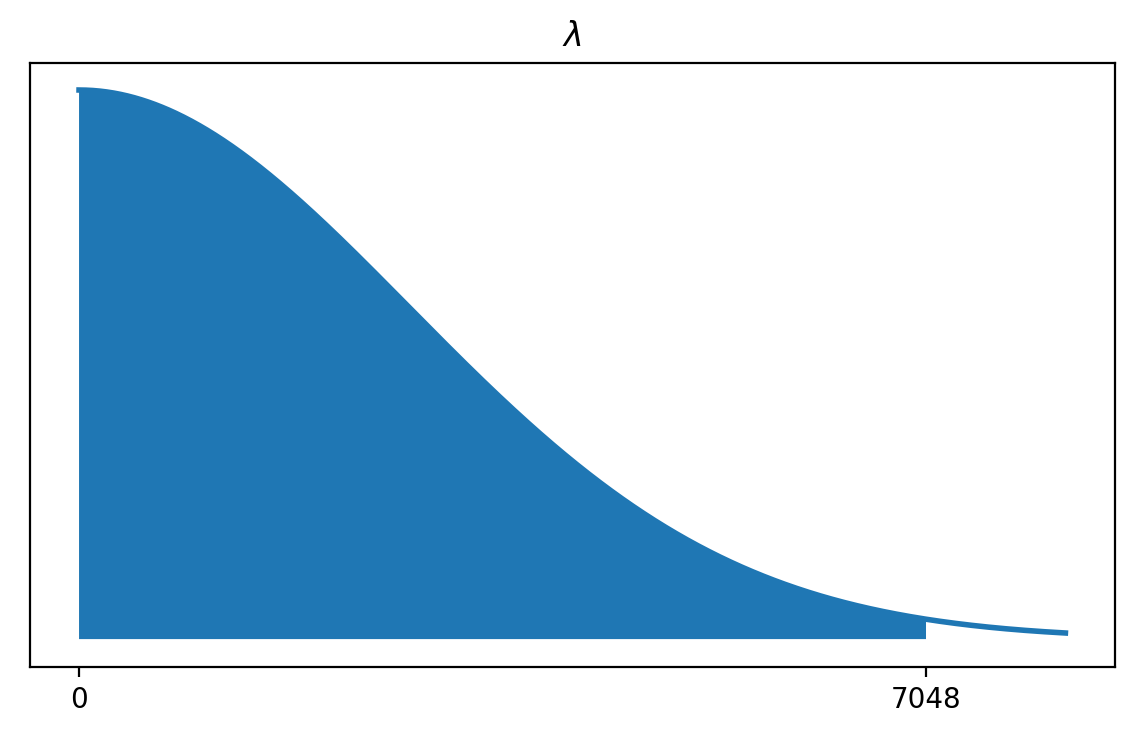

In [6]:
fig, ax2 = plt.subplots(1, 1,figsize=(7, 4))
x2 = np.linspace(0, 3*sigma, 1000)
x4 = np.linspace(0, lam_ub[0], 1000)
ax2.plot(x2, 2*stats.norm.pdf(x2,scale=sigma), linewidth=2)
ax2.fill_between(x4, 2*stats.norm.pdf(x4, scale=sigma), 0)
ax2.set_yticks([])
ax2.set_xticks([0, lam_ub[0]])
ax2.set_title(r'$\lambda$')
plt.show()

Now we can use stan to simulate possible outputs and parameters based only on prior information.

In [7]:
with open('prior_pred.stan', 'r') as file:
    print(file.read())

data {
  int M;
}

generated quantities {
  real lambda=fabs(normal_rng(0, 2736));
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(lambda);
  }
}


In [8]:
model = stan_utility.compile_model('prior_pred.stan')

Using cached StanModel


In [9]:
R = 1000
sim = model.sampling(data={'M':1},
                     algorithm="Fixed_param",
                     iter=R,
                     warmup=0,
                     chains=1, 
                     refresh=R,
                     seed=29042020)
params = sim.extract()
theta = params['lambda']
y_sim = params['y_sim']

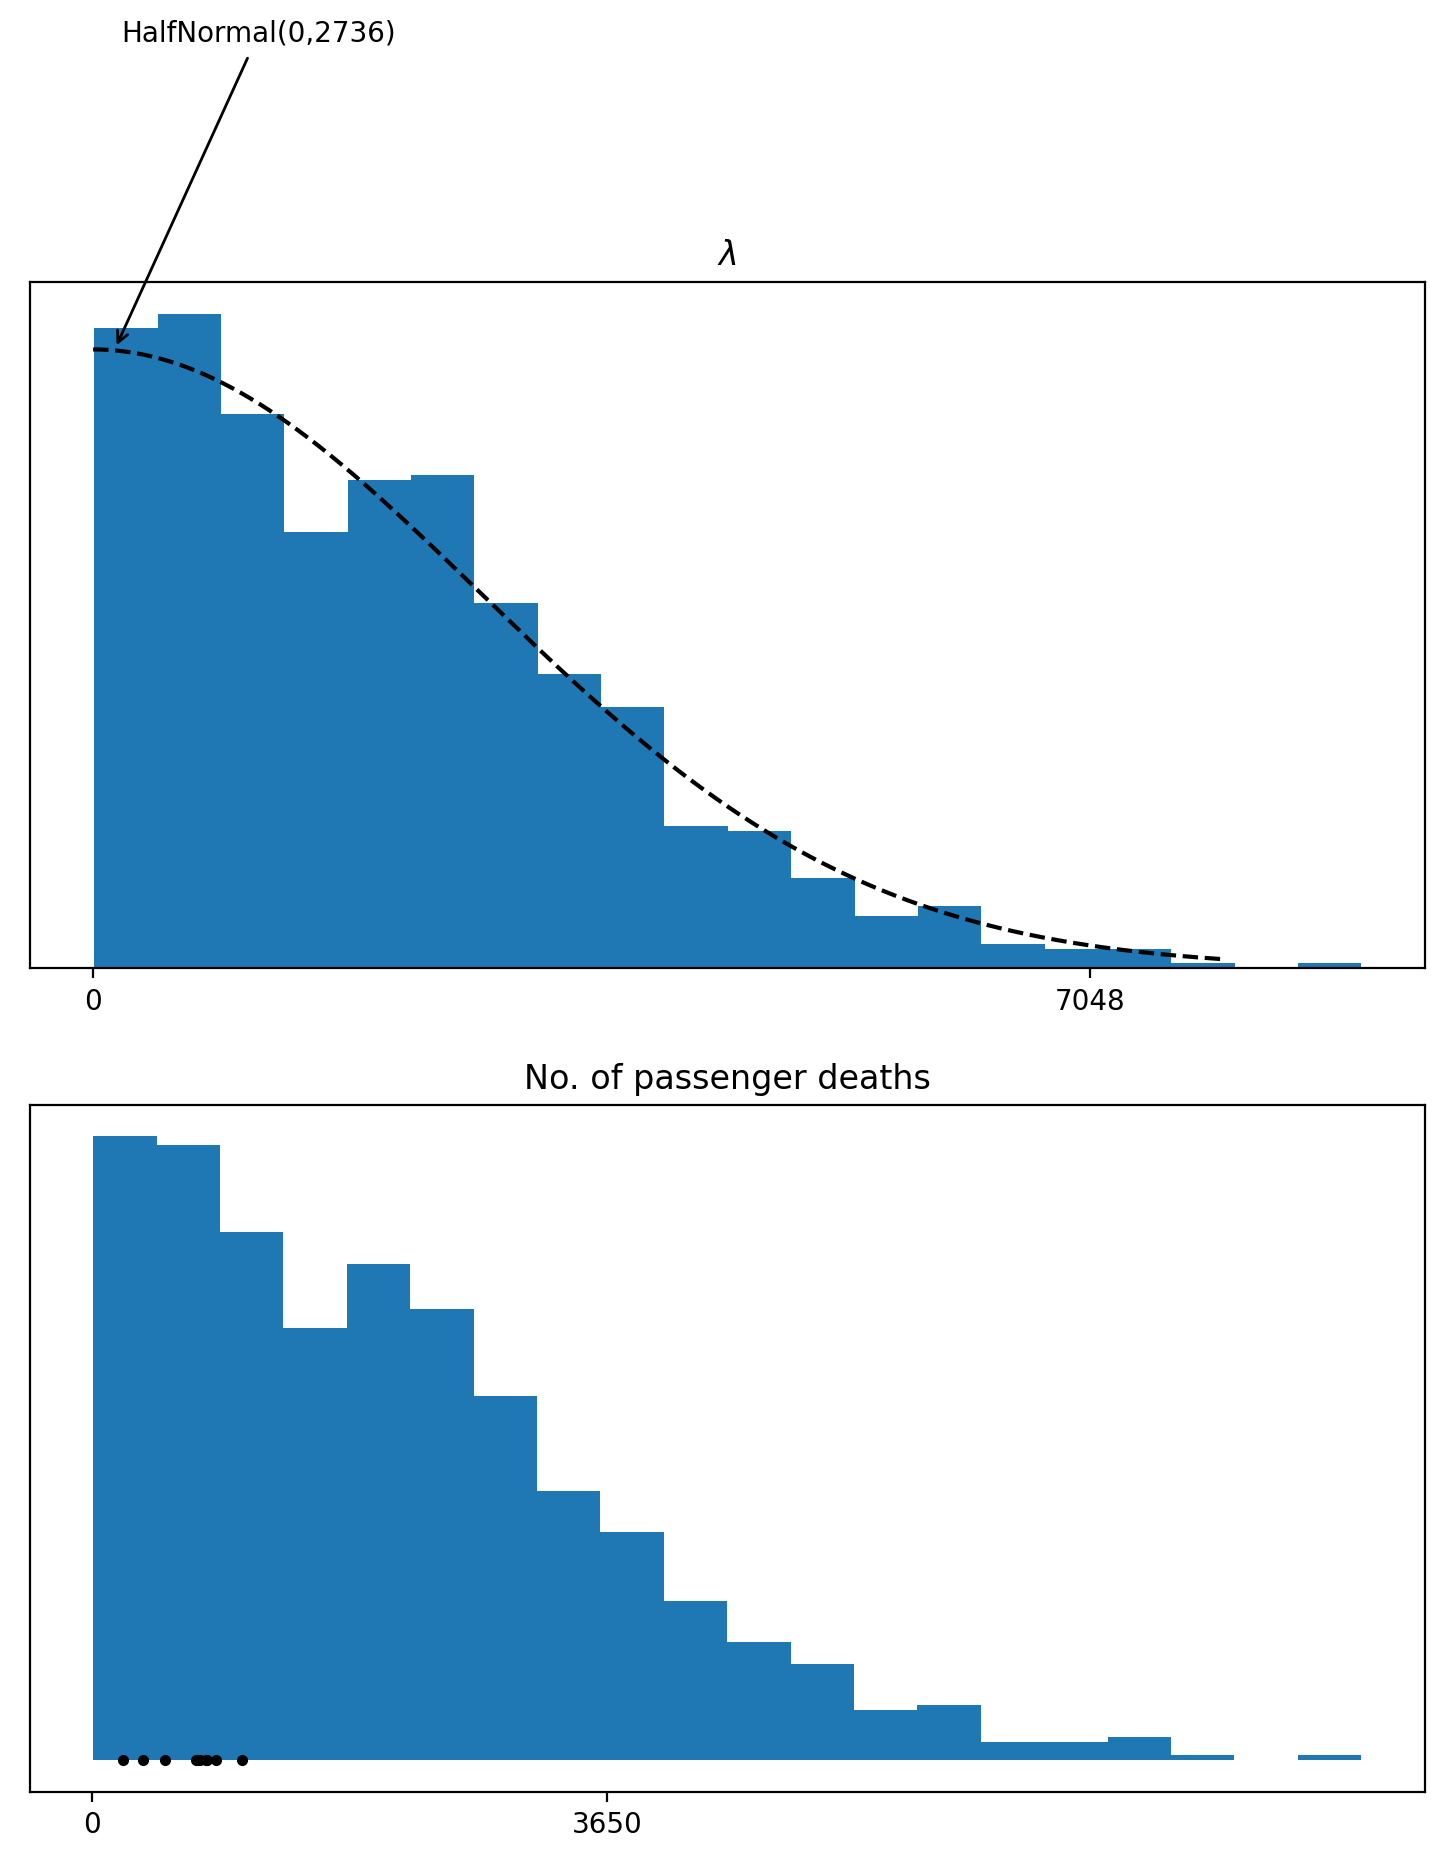

In [10]:
fig, axes = plt.subplots(2, 1,figsize=(9, 10))
ax1 = axes[0]
ax1.hist(theta, bins=20, density=True)
x = np.linspace(0, 8000, 2000)
ax1.set_xticks([0, lam_ub[0]])
ax1.set_yticks([])
ax1.set_title(r'$\lambda$')
ax1.plot(x, 2 * stats.norm.pdf(x, 0, sigma), color='black', linestyle='--')
arr_y_loc = 2 * stats.norm.pdf(150,0,sigma)
ax1.annotate('HalfNormal(0,' + str(np.int(sigma)) + ')', xy=(150,arr_y_loc), xytext=(200,1.5*arr_y_loc), arrowprops={'arrowstyle':'->'})
ax2 = axes[1]
ax2.hist(y_sim.flatten(), density=True, bins=20, zorder=1)
ax2.scatter(deaths, 0.0000002 * dta_cnt, color='black', marker='.', zorder=2)
ax2.set_xticks([0,3650])
ax2.set_yticks([])

ax2.set_title('No. of passenger deaths')
plt.show()

### Posterior inference and posterior predictive checks

In [11]:
with open('airline_posterior.stan', 'r') as file:
    print(file.read())

data {
  int M;
  int y[M];
}
parameters {
  real<lower=0>lambda;
}
model {
  lambda ~ normal(0,121);
  for (k in 1:M) {
    y[k] ~ poisson(lambda);
  }
}
generated quantities {
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(lambda);
  }
}


In [12]:
model = stan_utility.compile_model('airline_posterior.stan')

Using cached StanModel


In [13]:
data = dict(M = len(df),
            y = df['Passenger deaths'])
fit = model.sampling(data=data, seed=8052020)

params = fit.extract()
lam = params['lambda']
y_sim = params['y_sim']

mean_lam = np.mean(lam)
cinf_lam = az.hpd(lam, 0.89)

hpd_width = cinf_lam[1] - cinf_lam[0]

print('Mean lambda : {:4.2f}'.format(mean_lam))
print('89% confidence interval: [',*['{:4.2f}'.format(k) for k in cinf_lam],']')

Mean lambda : 688.68
89% confidence interval: [ 674.91 701.78 ]


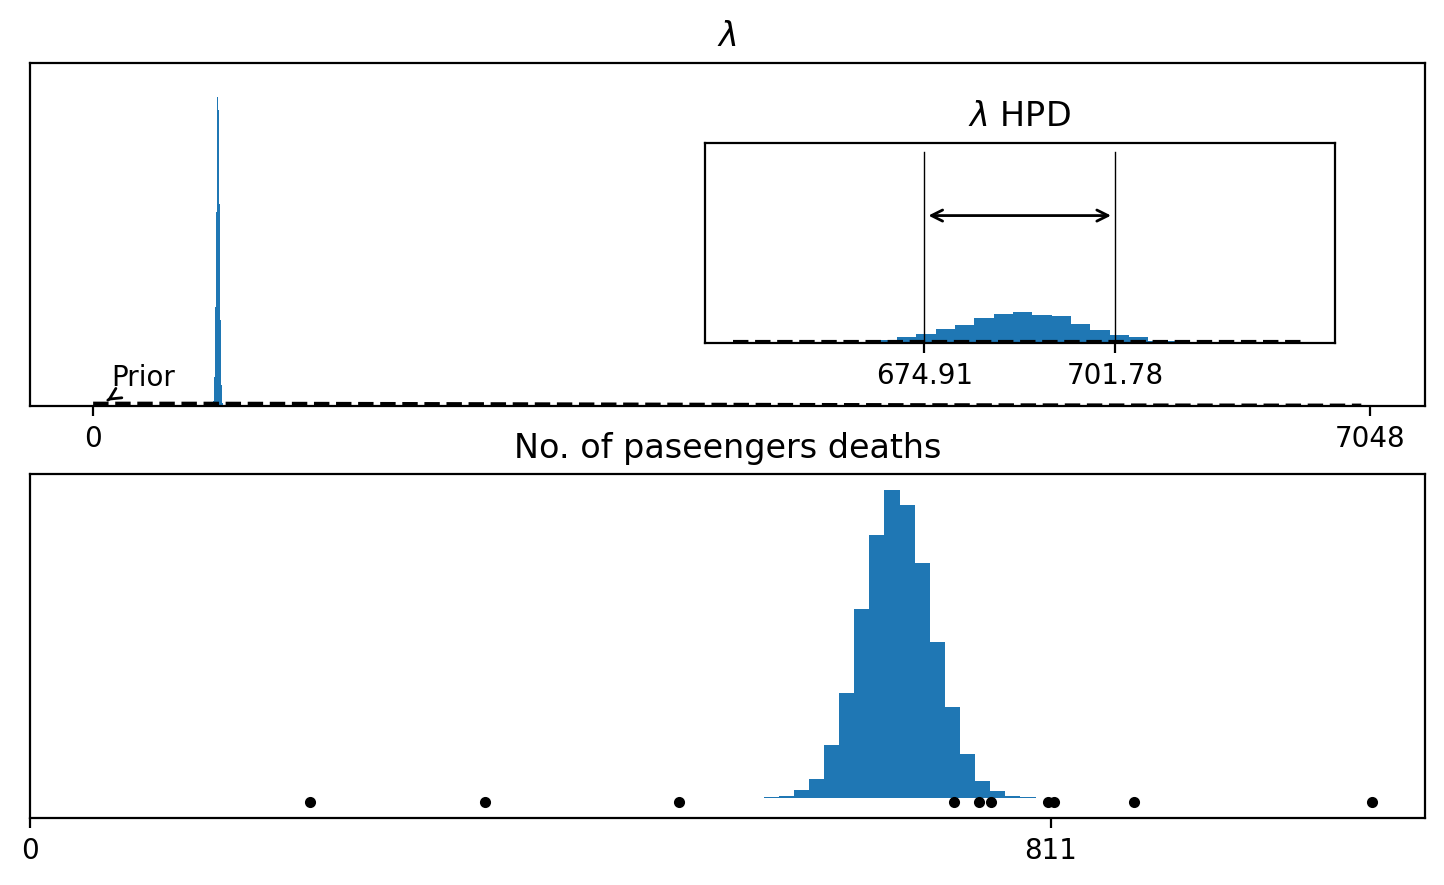

In [14]:
fig, axes = plt.subplots(2, 1,figsize=(9, 5))
ax1 = axes[0]
ax1.hist(lam, bins=20, density=True)
x = np.linspace(0, 7000, 100)

ax1.plot(x, 2 * stats.norm.pdf(x, 0, sigma), color='black', linestyle='--')
arr_y_loc = 2 * stats.norm.pdf(50, 0, sigma)
ax1.annotate('Prior', xy=(50, arr_y_loc), xytext=(100, 10 * arr_y_loc), arrowprops={'arrowstyle':'->'})
ax1.set_xticks([0, lam_ub[0]])
ax1.set_yticks([])
ax1.set_title(r'$\lambda$')

ax_sm = plt.axes([0.5,0.6,0.35,0.2])
x_sm = np.linspace(cinf_lam[0]-hpd_width,cinf_lam[1]+hpd_width,200)
ax_sm.hist(lam, bins=20, density=True)
ax_sm.plot(x_sm, 2 * stats.norm.pdf(x_sm, 0, sigma), color='black', linestyle='--')
ax_sm.annotate(s='', xy=(cinf_lam[0] - .2, 0.2), xytext=(cinf_lam[1] + .2, 0.2), arrowprops=dict(arrowstyle='<->'))
ax_sm.plot([cinf_lam[0], cinf_lam[0]], [0, 0.3], color='black', linestyle='-', linewidth=0.5)
ax_sm.plot([cinf_lam[1], cinf_lam[1]], [0, 0.3], color='black', linestyle='-', linewidth=0.5)

ax_sm.set_xticks(np.round([cinf_lam[0], cinf_lam[1]],2))
ax_sm.set_yticks([])
ax_sm.set_title(r'$\lambda$ HPD')


ax2 = axes[1]
ax2.hist(y_sim.flatten(), density=True, bins=20, zorder=1)
ax2.scatter(deaths, 0.0002 * dta_cnt, color='black', marker='.', zorder=2)
ax2.set_xticks([0, np.max(y_sim)])
ax2.set_yticks([])

ax2.set_title('No. of paseengers deaths')
plt.show()

In [15]:
median_y_sim = np.median(y_sim.flatten())
cinf_y_sim = az.hpd(y_sim.flatten(), 0.89)

print('Median of predicted accidents =', median_y_sim)
print('Confidence interval = [', *cinf_y_sim,']')

Median of predicted accidents = 689.0
Confidence interval = [ 642.0 730.0 ]


Model has predicted close but a little bit higher value. Real value of passenger deaths in 1986 was 546.

# Task 2
In this task intensity ($\theta$) is constant but rate ($\lambda$) is product of intensity and miles flown ($\bar{n}$). Number of passengers deaths ($y_i$) has Poisson distribution:$$y_i\sim\mathrm{Poisson}(\lambda)$$

Similarly to previous task 20 people dying every day has very low probability (20 * 365 = 7300). This time we assume that $\lambda=\theta\cdot\bar{n}$. This gives us condition$$\theta\cdot\bar{n}+3\sqrt{\theta\cdot\bar{n}}\approx7300$$

We need to assign the prior for $\theta$ that would have probability of smaller $\lambda$ equal 99%.

In [16]:
mean_miles = np.mean(df['Miles flown [100 mln miles]'])
root_of_theta = np.polynomial.polynomial.polyroots([-7300 / mean_miles, 3. / np.sqrt(mean_miles), 1.])
theta_ub = (root_of_theta[root_of_lam > 0] ** 2)
print('theta upper bound','{:4.3f}'.format(theta_ub[0]))

theta upper bound 1.233


In [17]:
model = stan_utility.compile_model('prior_tune.stan')

Using cached StanModel


In [18]:
data = dict(y_guess=np.array([np.log(1)]), theta=np.array(theta_ub))

sim = model.sampling(data=data,
                          seed=1052020,
                          algorithm="Fixed_param",
                          iter=1, 
                          warmup=0,
                          chains=1)
sigma = (sim.extract()['sigma'][0])
print('sigma =','{:4.3f}'.format(sigma))

sigma = 0.479


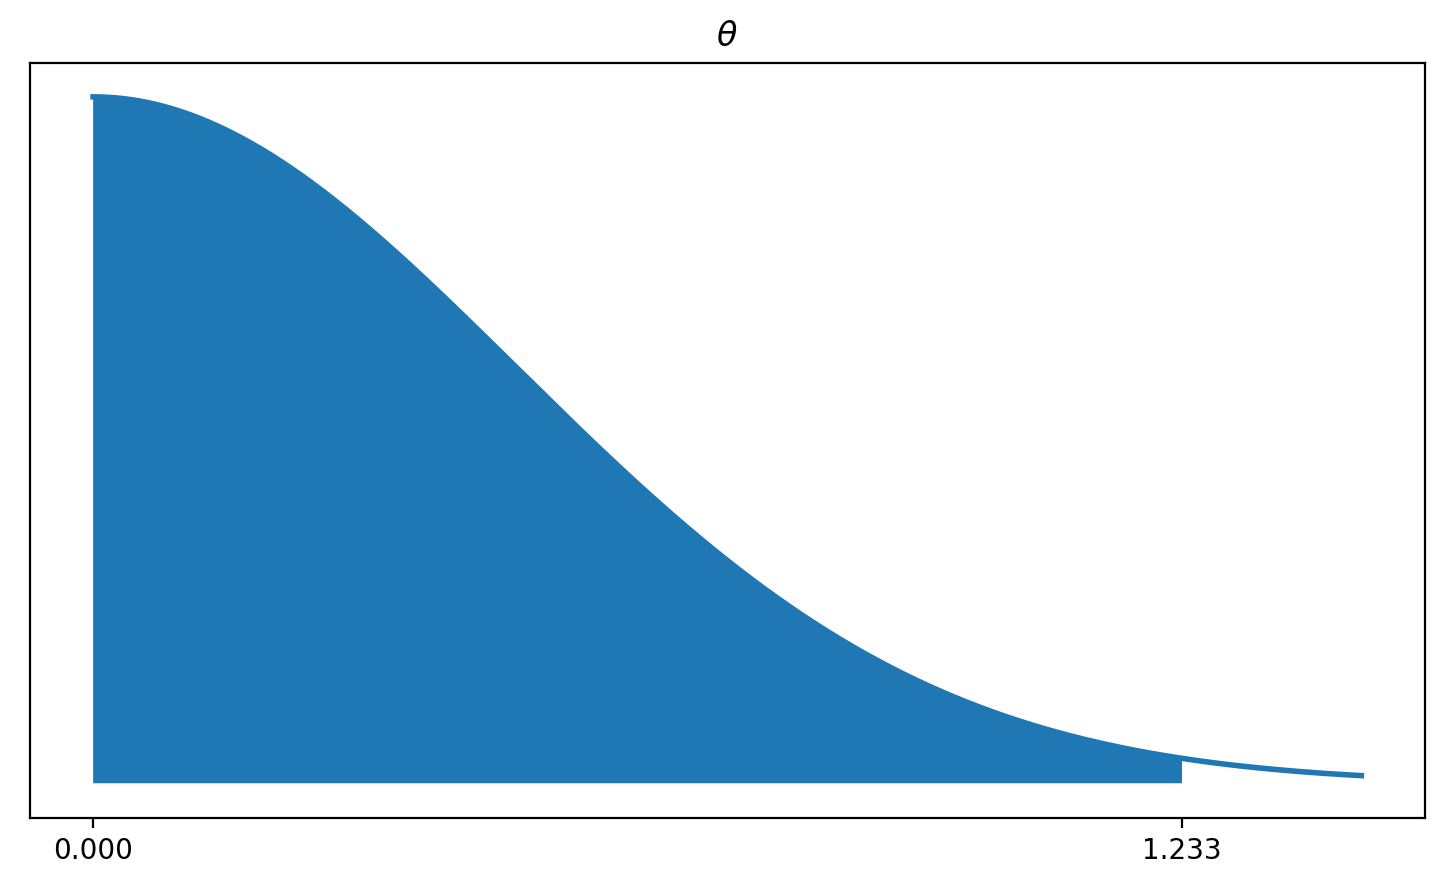

In [19]:
fig, ax2 = plt.subplots(1, 1, figsize=(9, 5))
x2 = np.linspace(0, 3 * sigma, 1000)
x4 = np.linspace(0, theta_ub[0], 1000)
ax2.plot(x2, 2 * stats.norm.pdf(x2, scale=sigma), linewidth=2)
ax2.fill_between(x4, 2 * stats.norm.pdf(x4, scale=sigma), 0)
ax2.set_yticks([])
ax2.set_xticks([0, theta_ub[0]])
ax2.set_title(r'$\theta$')
plt.show()

### Prior predictive distribution
Now we will use stan to simulate possible outputs and parameteres based only on prior information.

In [20]:
with open('prior_distance.stan', 'r') as file:
    print(file.read())

data {
  int M;
  vector[M] miles;
}
generated quantities {
  real theta = fabs(normal_rng(0, 0.479));
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(theta*miles[k]);
  }
}


In [21]:
model = stan_utility.compile_model('prior_distance.stan')

Using cached StanModel


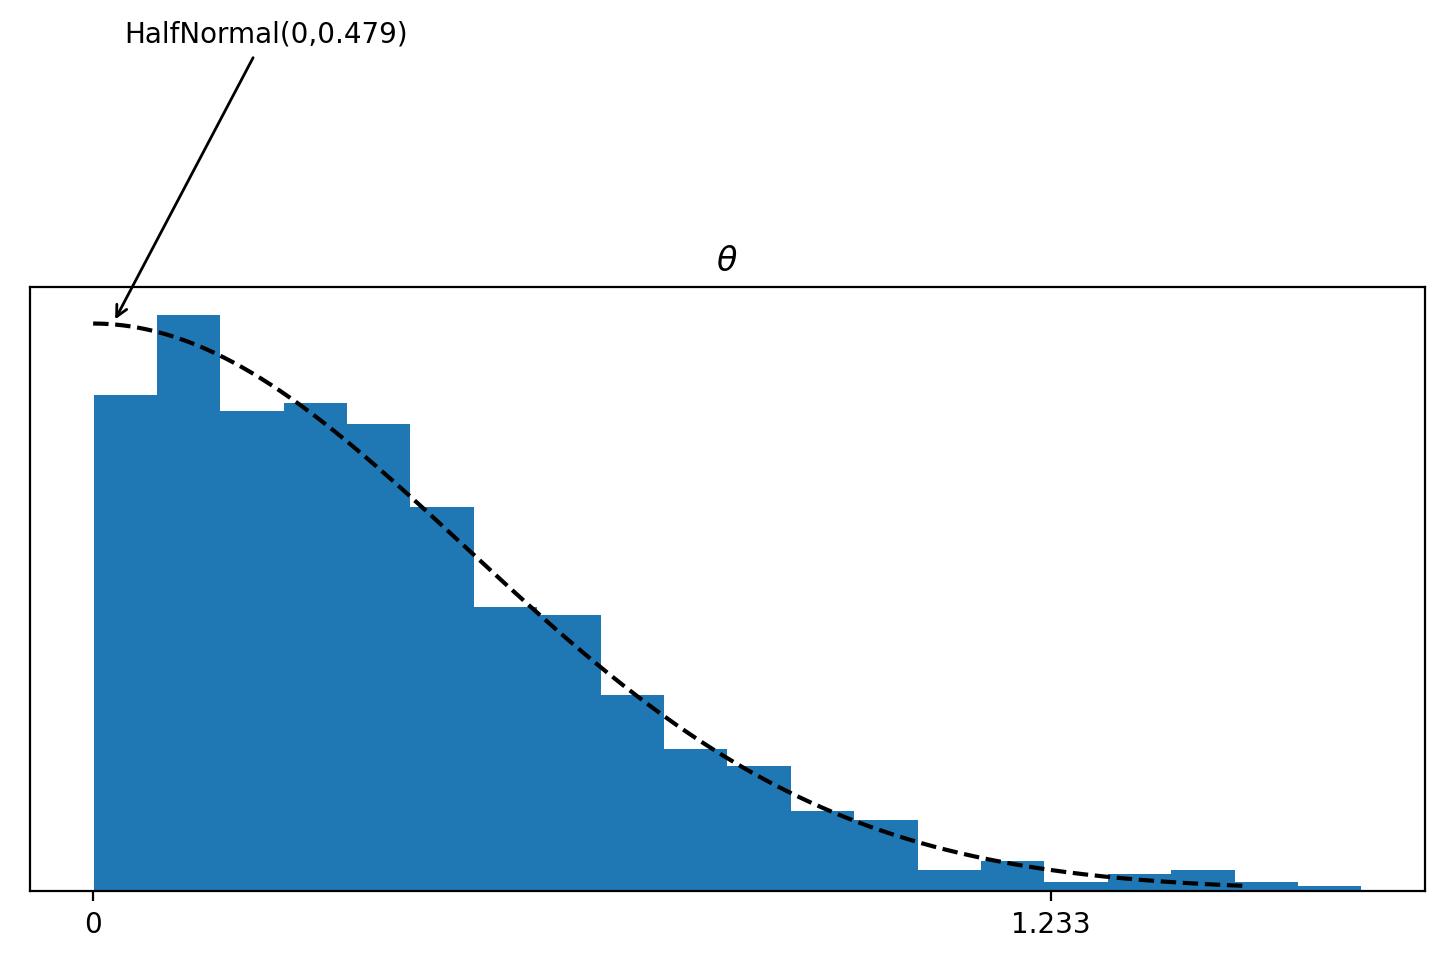

In [22]:
R=1000
data = dict(M=len(df),miles=df['Miles flown [100 mln miles]'].to_numpy())
sim = model.sampling(data=data, algorithm="Fixed_param", iter=R, warmup=0, chains=1, refresh=R, seed=29042020)

params = sim.extract()
theta = params['theta']

fig, axes = plt.subplots(1, 1,figsize=(9, 4))
ax1 = axes
ax1.hist(theta, bins=20, density=True)
x = np.linspace(0, 1.2 * theta_ub[0], 2000)
ax1.set_xticks([0, theta_ub[0]])
ax1.set_xticklabels([0, np.round(theta_ub[0], 3)])
ax1.set_yticks([])
ax1.set_title(r'$\theta$')
ax1.plot(x, 2 * stats.norm.pdf(x, 0, sigma), color='black', linestyle='--')
arr_y_loc = 2 * stats.norm.pdf(0.025, 0, sigma)
ax1.annotate('HalfNormal(0,' + '{:4.3f}'.format(sigma) + ')',xy=(0.025, arr_y_loc), xytext=(0.04, 1.5 * arr_y_loc), arrowprops={'arrowstyle':'->'})
plt.show()

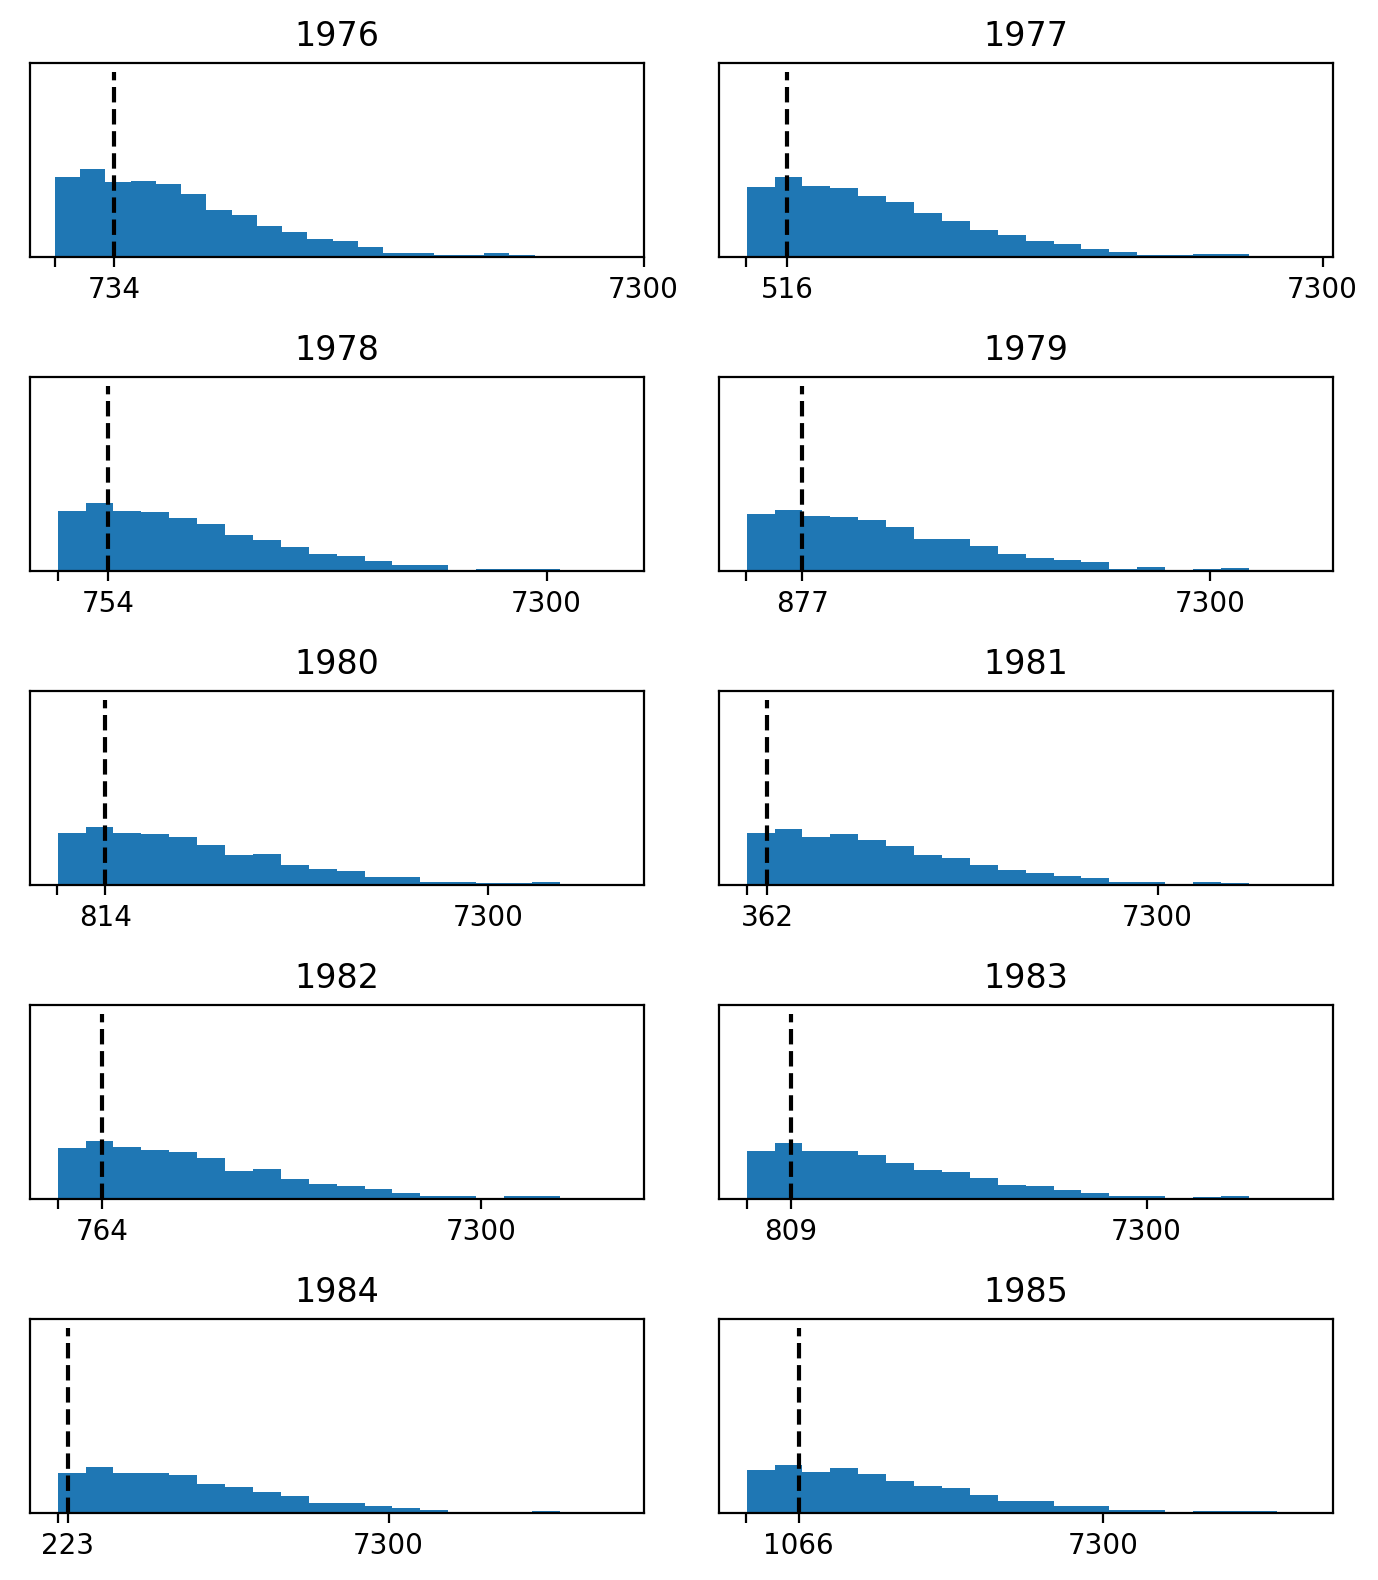

In [23]:
y_sim = params['y_sim']
fig, axes = plt.subplots(5, 2, figsize=(7, 8), sharey=True, squeeze=False)
axes_flat = axes.flatten()
for k, ax in enumerate(axes_flat):
    ax.hist(y_sim[:,k], bins=20, density=True)
    ax.set_title(df['Year'][k])
    tv = df['Passenger deaths'].iloc[k]
    ax.plot([tv,tv], [0,0.0009], linestyle='--', color='black')
    ax.set_yticks([])
    ax.set_xticks([0, tv, 7300])
    ax.set_xticklabels(['', tv, 7300])

fig.tight_layout()

plt.show()

### Posterior inference and posterior predictive checks

In [24]:
with open('posterior_distance.stan', 'r') as file:
    print(file.read())

data {
  int M;
  vector[M] miles;
  int y[M];
}
parameters {
  real<lower=0>theta;
}
model {
  theta ~ normal(0, 0.479);
  for (k in 1:M) {
    y[k] ~ poisson(miles[k] * theta);
  }
}
generated quantities {
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(miles[k] * theta);
  }
}


In [25]:
model = stan_utility.compile_model('posterior_distance.stan')

Using cached StanModel


In [26]:
data = dict(M = len(df),
            miles = df['Miles flown [100 mln miles]'],
            y = df['Passenger deaths'])
fit = model.sampling(data=data, seed=8052020)

params = fit.extract()
theta = params['theta']
y_sim = params['y_sim']

mean_theta = np.mean(theta)
cinf_theta = az.hpd(theta, 0.89)
hpd_width = cinf_theta[1] - cinf_theta[0]


print('Mean theta : {:5.4f}'.format(mean_theta))
print('95% confidence interval: [',*['{:5.4f}'.format(k) for k in cinf_theta],']')

Mean theta : 0.1211
95% confidence interval: [ 0.1188 0.1233 ]


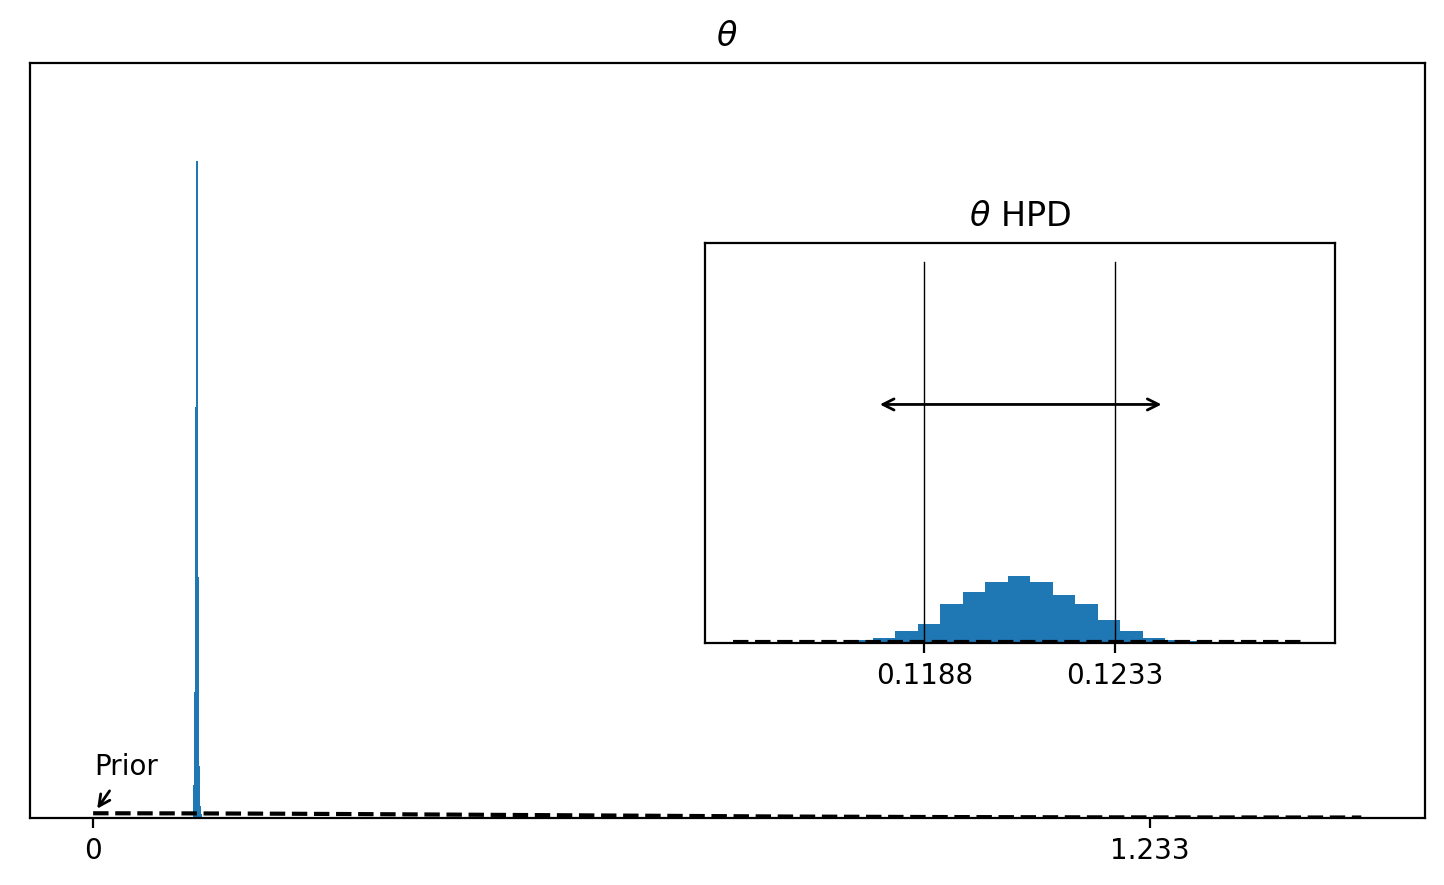

In [27]:
fig, axes = plt.subplots(1, 1, figsize=(9, 5))
ax1 = axes
ax1.hist(theta, bins=20, density=True)
x = np.linspace(0, 1.2 * theta_ub[0], 5000)
ax1.set_xticks([0, theta_ub[0]])
ax1.set_xticklabels([0, np.round(theta_ub[0], 3)])
ax1.set_yticks([])
ax1.set_title(r'$\theta$')
ax1.plot(x, 2 * stats.norm.pdf(x, 0, sigma), color='black', linestyle='--')
arr_y_loc = 2 * stats.norm.pdf(0.001, 0, sigma)
ax1.annotate('Prior', xy=(0.001, arr_y_loc), xytext=(0.0015, 10 * arr_y_loc), arrowprops={'arrowstyle':'->'})

ax_sm = plt.axes([0.5,0.3,0.35,0.4])
x_sm = np.linspace(cinf_theta[0] - hpd_width, cinf_theta[1] + hpd_width, 200)
ax_sm.hist(theta, bins=20, density=True)
ax_sm.plot(x_sm, 2 * stats.norm.pdf(x_sm, 0, sigma), color='black', linestyle='--')
ax_sm.annotate(s='', xy=(0.99 * cinf_theta[0], 1000), xytext=(1.01 * cinf_theta[1], 1000), arrowprops=dict(arrowstyle='<->'))
ax_sm.plot([cinf_theta[0], cinf_theta[0]], [0,1600], color='black', linestyle='-', linewidth=0.5)
ax_sm.plot([cinf_theta[1], cinf_theta[1]], [0,1600], color='black', linestyle='-', linewidth=0.5)

ax_sm.set_xticks(([cinf_theta[0], cinf_theta[1]]))
ax_sm.set_xticklabels(np.round([cinf_theta[0], cinf_theta[1]], 4))

ax_sm.set_yticks([])
ax_sm.set_title(r'$\theta$ HPD')

plt.show()

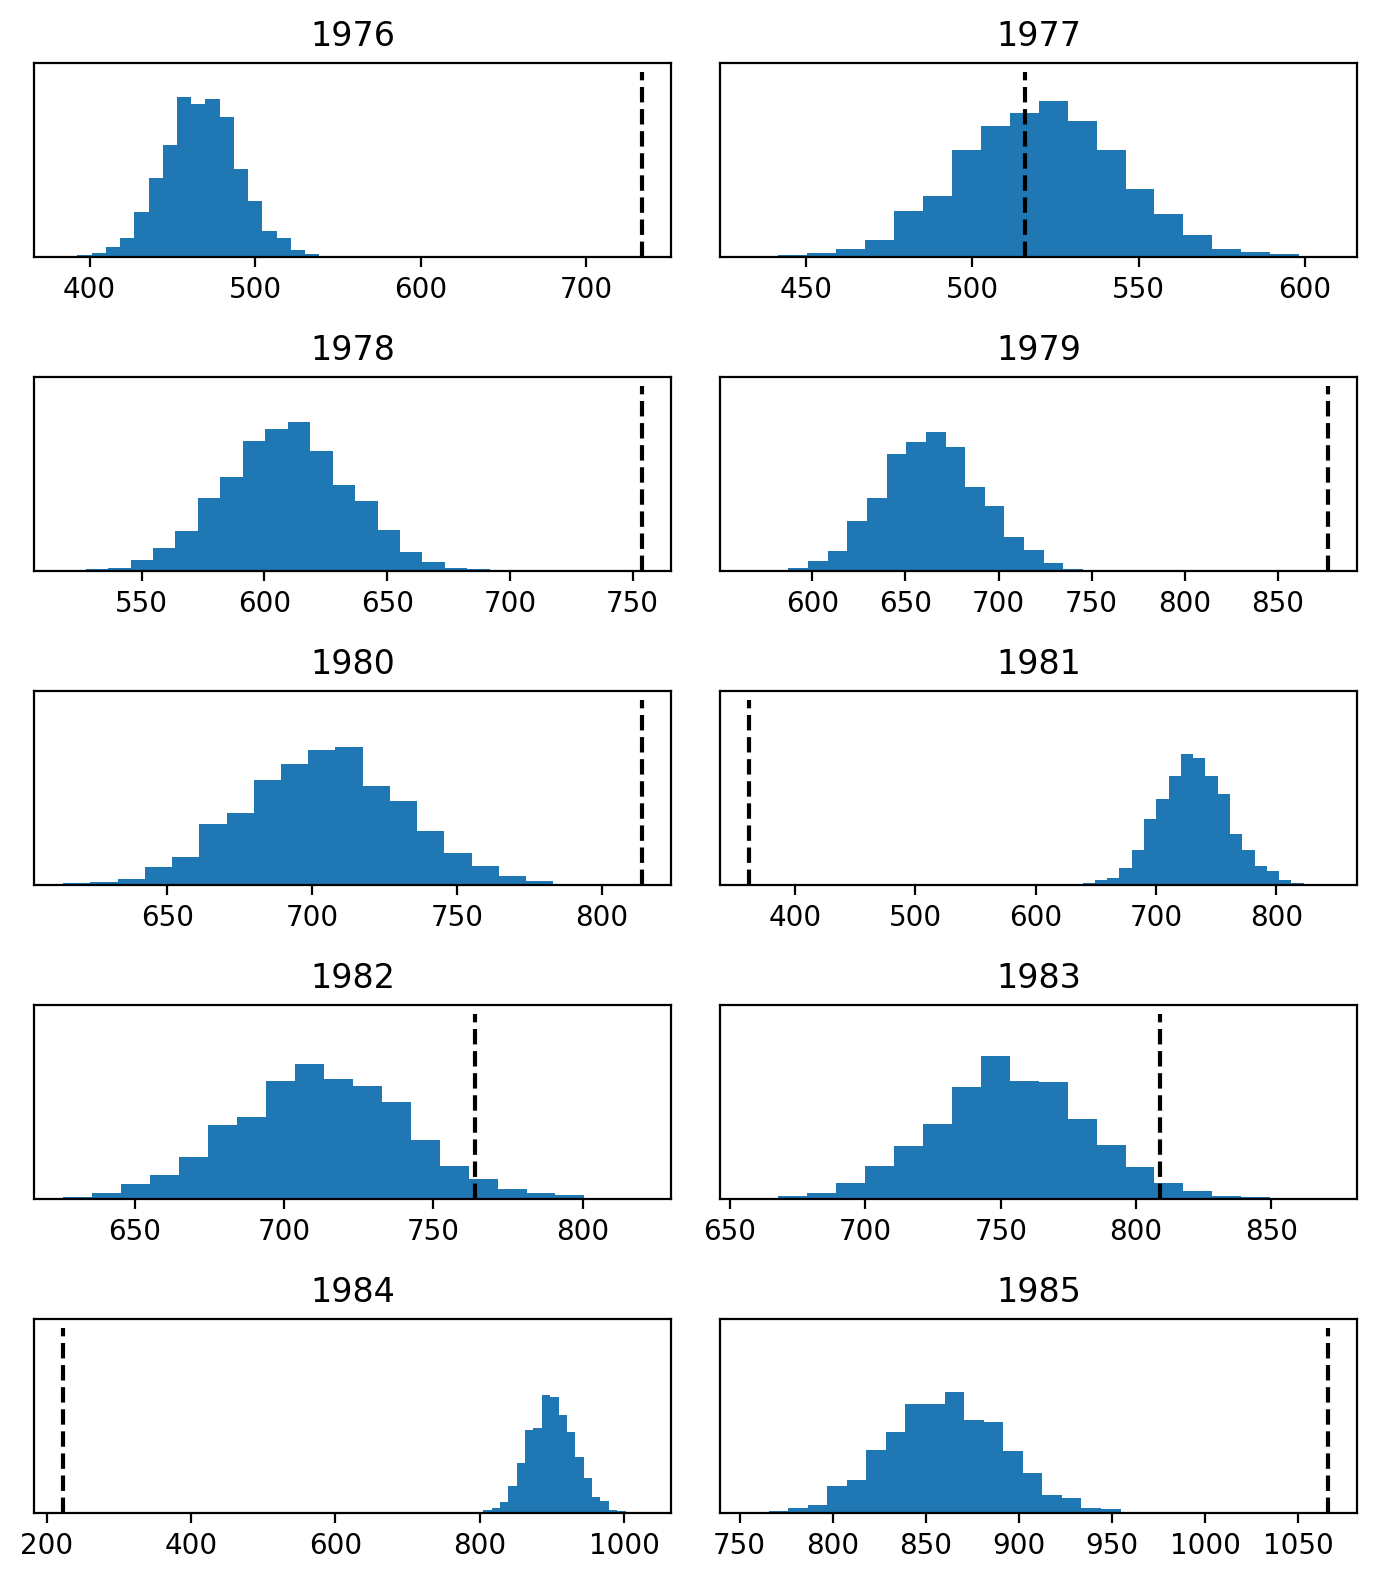

In [28]:
y_sim = params['y_sim']
fig, axes = plt.subplots(5, 2, figsize=(7, 8), sharey=True, squeeze=False)
axes_flat = axes.flatten()
for k, ax in enumerate(axes_flat):
    ax.hist(y_sim[:,k], bins=20, density=True)
    ax.set_title(df['Year'][k])
    tv = df['Passenger deaths'].iloc[k]
    ax.plot([tv, tv], [0, 0.02], linestyle='--', color='black')
    ax.set_yticks([])

fig.tight_layout()
plt.show()

### Using model for prediction
Lets predict number of passenger death. There were 546 death and 0.06 death per 100 000 000 miles flown in 1986.

In [29]:
miles1986 = 546 / 0.06
print(np.round(miles1986))

9100.0


In [30]:
with open('post_distance.stan', 'r') as file:
    print(file.read())

data {
  int M;
  vector[M] miles;
  int y[M];
}
parameters {
  real<lower=0>theta;
}
model {
  theta ~ normal(0, 0.479);
  for (k in 1:M) {
    y[k] ~ poisson(miles[k]*theta);
  }
}
generated quantities {
  int y_1986 = poisson_rng(9100 * theta);
}


In [31]:
model = stan_utility.compile_model('post_distance.stan')

Using cached StanModel


In [32]:
data = dict(M = len(df),
            miles = df['Miles flown [100 mln miles]'],
            y = df['Passenger deaths'])
fit = model.sampling(data=data, seed=8052020)
y_1986 = fit.extract()['y_1986']

median_y_1986 = np.median(y_1986)
cinf_y_1986 = az.hpd(y_1986, 0.89)

print('Median of predicted deaths =',median_y_1986)
print('Confidence interval = [',*cinf_y_1986,']')

Median of predicted deaths = 1103.0
Confidence interval = [ 1049.0 1160.0 ]


Prediction using this model wasn't accurate at all. Better results were achieved with previous model.